In [1]:
%matplotlib inline

# Datasets y Dataloaders

El código para procesar muestras de datos puede resultar complicado y difícil de mantener; idealmente queremos que nuestro código de conjunto de datos se desacople de nuestro código de entrenamiento  para una mejor legibilidad y modularidad.
PyTorch proporciona dos primitivas de datos: `torch.utils.data.DataLoader` y `torch.utils.data.Dataset` que permiten usar conjuntos de datos precargados, o datos propios. `Dataset` almacena las muestras y sus etiquetas correspondientes, y `DataLoader` las envuelve un iterable `Dataset` para permitir un fácil acceso a las muestras.

PyTorch proporcionan una serie de conjuntos de datos precargados que implementan funciones específicas para los datos. Se pueden utilizar para crear prototipos y comparar su modelo. Puede encontrarlos aquí:
 * [Conjuntos de datos de imagen](https://pytorch.org/vision/stable/datasets.html)
 * [Conjuntos de datos de texto](https://pytorch.org/text/stable/datasets.html)
 * [Conjuntos de datos de audio](https://pytorch.org/audio/stable/datasets.html)

## Carga de un Dataset

A continuación, se muestra un ejemplo de cómo cargar el conjunto de datos Fashion-MNIST de TorchVision. Fashion-MNIST es un conjunto de datos de imágenes de artículos de Zalando que consta de 60.000 ejemplos de entrenamiento y 10.000 ejemplos de prueba. Cada ejemplo comprende una imagen en escala de grises de 28 × 28 y una etiqueta asociada de una de las 10 clases

Se carga FasionMNIST con los siguientes parámetros:
 * root es la ruta donde se almacenan los datos del train/test
 * train especifica si el conjunto de datos es de entrenamiento o de prueba
 * download=True descarga los datos de Internet si no están disponibles en root.
 * transform y target_transform especifican las transformaciones de características y etiquetas

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Vemos el número de mustras de entrenamiento y test

In [4]:
len(training_data), len(test_data)

(60000, 10000)

Veamos una muestra

In [13]:
sample_training_data = training_data[0]
len(sample_training_data)

2

Se puede ver que la dimensión de la muestra es 2, esto es porque la muestra contiene la imagen y la etiqueta, así que obtenemos solo la imagen

In [14]:
image_sample_training_data = sample_training_data[0]
image_sample_training_data.shape

torch.Size([1, 28, 28])

## Iterando y visualizando el Dataset

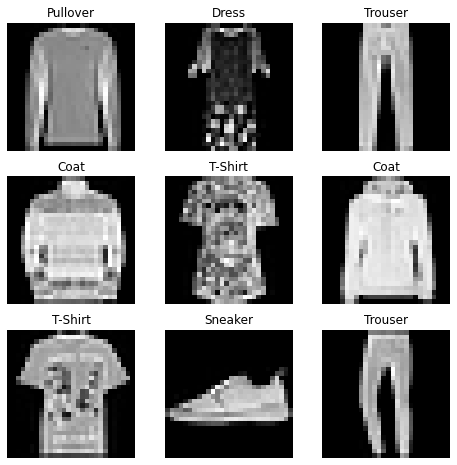

In [32]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  # squeeze elimina todas las dimensiones 1 de un tensor, 
                                            # si se le mete un tensor de dimensiones (Ax1xBxCx1xD) 
                                            # devuelve un tensor de dimensiones (AxBxCxD)
plt.show()

--------------




## Creación de un Dataset personalizado

Una clase de conjunto de datos personalizada debe implementar tres funciones: `__init__` , `__len__` y `__getitem__`. En este ejemplo, las imágenes de FashionMNIST se almacenan en un directorio img_diry sus etiquetas se almacenan por separado en un archivo CSV annotations_file.

In [16]:
import os
import pandas as pd
from torchvision.io import read_image

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### `__init__`
^^^^^^^^^^^^^^^^^^^^

La función __init__ se ejecuta una vez al crear una instancia del objeto Dataset. Inicializamos el directorio que contiene las imágenes, el archivo de anotaciones y ambas transformaciones (que se tratan con más detalle en la siguiente sección)

El archivo labels.csv se ve así:

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9



In [ ]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### `__len__`
^^^^^^^^^^^^^^^^^^^^

La función `__len__` devuelve el número de muestras en nuestro conjunto de datos

In [ ]:
def __len__(self):
    return len(self.img_labels)

### `__getitem__`
^^^^^^^^^^^^^^^^^^^^

La función `__getitem__` carga y devuelve una muestra del conjunto de datos en el índice dado idx. Según el índice, identifica la ubicación de la imagen en el disco, la convierte en un tensor usando `read_image`, recupera la etiqueta correspondiente de los datos csv en `self.img_labels`, llama a las funciones de transformación en ellos (si corresponde) y devuelve la imagen del tensor y la etiqueta correspondiente en una tupla.

In [ ]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

--------------




## Preparar los datos para entrenar con Dataloaders

Un Dataset recupera características de nuestro conjunto de datos y etiquetas de una muestra a la vez. Mientras entrenamos un modelo, normalmente queremos pasar muestras en "minibatches", reorganizar los datos en cada época para reducir el sobreajuste del modelo y usar multiprocessing para acelerar la recuperación de datos.

DataLoader es un iterable que nos abstrae esta complejidad en una API sencilla.

In [18]:
from torch.utils.data import DataLoader

In [19]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterar a través de DataLoader

Hemos cargado el conjunto de datos en `DataLoader` y podemos iterar a través del conjunto de datos según sea necesario. Cada iteración a continuación devuelve un lote de `train_features` y `train_labels` (que contiene `batch_size=64` características y etiquetas respectivamente). Debido a que especificamos `shuffle=True`, después de iterar sobre todos los lotes, los datos se mezclan (para un control más detallado sobre el orden de carga de datos, eche un vistazo a [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)).

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


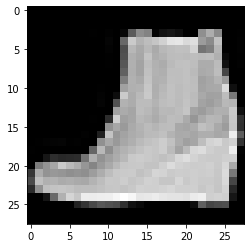

Label: 9


In [20]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()   # squeeze elimina todas las dimensiones 1 de un tensor, 
                                    # si se le mete un tensor de dimensiones (Ax1xBxCx1xD) 
                                    # devuelve un tensor de dimensiones (AxBxCxD)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")